In [1]:
#imports
import nest
import yaml
import nest.raster_plot
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, filtfilt
from analysis_functions import *
from asserting_functions import *
from yaml_io import *
from prepare_nest_parameters import *
#from spectrum_with_bands import *
from nest_reset_create_connect_simulate import *


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Jun 14 2024 10:44:24

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
is_verbose = False
debug_mode = True

#total sim, resolution and recording times
times = read_sim_and_recording_times_yaml(is_verbose)

#read general network parameters
config = read_general_config_yaml(is_verbose)

#prepare all simulation parameters
nest_pms={}
nest_pms = nest_parameters_preparation(times, config, is_verbose, nest_pms)
print("nest_pms",nest_pms)

in read_sim_and_recording_times_yaml: verbose mode is False
in read_general_config_yaml: verbose mode is False
in nest_parameters_preparation: verbose mode is False
in read_neural_parameters: verbose mode is False
in read_neural_parameters: verbose mode is False
nest_pms {'exc_pms': {'multi_compartment': False, 'neuron_kind': 'excitatory', 'equation_params': {'a': 0, 't_ref': 0.0, 'Delta_T': 2.0, 'C_m': 362.5648533496359, 'g_L': 6.666182946322264, 'tau_w': 500.0, 'V_th': -50.0, 'V_peak': -40.0, 'b_awake': 40.0, 'E_L_awake': -58.656837907086036, 'V_reset_awake': -62.12885359171539, 'b_NREM': 200.0, 'E_L_NREM': -63.656837907086036, 'V_reset_NREM': -62.12885359171539}}, 'contextual_poisson': {'awake': {'basic_rate': 3000.0, 'poisson_weight': 0.6, 'spreading_factor': 4, 'start_time': 6000.0, 'stop_time': 6500.0, 'target_pop': 2}}, 'sim_pms': {'stop_ms': 45000.0, 'resolution_ms': 0.1}, 'use_single_compartment_environment': True, 'exc_neu_params': {'receptors': {}, 'equation_params': {'a': 0

In [3]:
NEST_version = nest.__version__
if NEST_version == "3.7.0" and nest_pms["use_single_compartment_environment"]==False:
    print("ASSERTION ERROR: Ca-AdEx multi-compartment neuron not supported by this NEST version", NEST_version)
    assert(False)

In [4]:
num_threads=4
sim_completed, spike_recorders, inh_spike_recorder = nest_reset_create_connect_simulate(nest_pms,num_threads)
print("sim_completed", sim_completed)

IN nest_reset_create_connect_simulate: use_single_compartment_environment = True

Aug 16 23:11:22 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Aug 16 23:11:22 NodeManager::prepare_nodes [Info]: 
sim_completed True
    Preparing 208 nodes for simulation.

Aug 16 23:11:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 208
    Simulation time (ms): 45000
    Number of OpenMP threads: 4
    Not using MPI

Aug 16 23:11:39 SimulationManager::run [Info]: 
    Simulation finished.


In [5]:
d_inh = nest.GetStatus(inh_spike_recorder, "events")[0]

In [6]:
#before analysis, preliminary sim look 
preliminary_sim_look(debug_mode,nest_pms, spike_recorders, inh_spike_recorder, nest_pms["recording_pms"])   

pop 0 first recorded event at time 5011.2 from sender 20
pop 0 last recorded event at time 44947.0 from sender 7
pop 0 total_exc_pop_spikes= 3678
pop 0 average_exc_pop_firing_rate_Hz= 4.5975 Hz
pop 1 first recorded event at time 5026.400000000001 from sender 40
pop 1 last recorded event at time 44908.9 from sender 39
pop 1 total_exc_pop_spikes= 3664
pop 1 average_exc_pop_firing_rate_Hz= 4.58 Hz
pop 2 first recorded event at time 5024.5 from sender 52
pop 2 last recorded event at time 44927.6 from sender 55
pop 2 total_exc_pop_spikes= 3775
pop 2 average_exc_pop_firing_rate_Hz= 4.71875 Hz
pop 3 first recorded event at time 5146.1 from sender 72
pop 3 last recorded event at time 44947.0 from sender 75
pop 3 total_exc_pop_spikes= 3652
pop 3 average_exc_pop_firing_rate_Hz= 4.565 Hz
INHIBITORIES 3 first recorded event at time 5025.2 from sender 84
INHIBITORIES 3 last recorded event at time 44999.3 from sender 99
INHIBITORIES 3 total_inh_pop_spikes= 22700
INHIBITORIES 3 average_inh_firing_rat

In [7]:
#setting the analysis parameters
default_cropping=True

if default_cropping:
    crop_start_ms=nest_pms["recording_pms"]["start_ms"] 
    crop_stop_ms=nest_pms["recording_pms"]["stop_ms"] 
else:
    crop_start_ms = 000.0 + nest_pms["recording_pms"]["start_ms"]
    crop_stop_ms= 200.0 + nest_pms["recording_pms"]["start_ms"]

crop_pms={"start_ms":crop_start_ms, 
          "stop_ms":crop_stop_ms}
crop_pms["duration_ms"]=crop_pms["stop_ms"]-crop_pms["start_ms"]

#switch-case decision of spectral_window_ms based on the value of the crop_duration_ms
def spectral_window_ms_analysis_switch(crop_duration_ms):
    if crop_duration_ms<4000.0:
        spectral_window_ms=crop_duration_ms/4.0
        return spectral_window_ms
    if crop_duration_ms <= 8000.0:
        spectral_window_ms = 1000.0
        return spectral_window_ms
    if crop_duration_ms <= 16000.0:
        spectral_window_ms = 2000.0
        return spectral_window_ms
    else:
        spectral_window_ms = 4000.0
        return spectral_window_ms
        
default_spectral_analysis=True

if default_spectral_analysis:
    spectrogram_window_ms=spectral_window_ms_analysis_switch(crop_pms["duration_ms"])
else:
    spectrogram_window_ms=1000.0
   
sampling_pms={"spikes_sampling_window_ms": 0.2,
              "spectrogram_window_ms":spectrogram_window_ms,
              "low_freq_sampling_window_ms":12.5}

analysis_pms={}                                 
analysis_pms.update(derive_analysis_pms_from_sampling_pms(sampling_pms))
  
#assertions on crop, recording and spectrogram params
check_analysis_pms(crop_pms,nest_pms["recording_pms"],analysis_pms)

# Assuming spike_recorders is a list of spike recorder IDs previously created in your NEST simulation
cropped_events = crop_events_from_spike_recorders(crop_pms, spike_recorders)
"""
print("type of cropped_events",type(cropped_events), len(cropped_events))
print(cropped_events)
"""
cropped_inh_events = crop_inh_events(crop_pms, inh_spike_recorder)
"""
print("type of cropped_inh_events",type(cropped_inh_events), len(cropped_inh_events))
print(cropped_inh_events)
"""
#print the set of analysis parameters
analysis_pms_print(nest_pms["recording_pms"],crop_pms,analysis_pms)

---RECORDING INTERVAL---
start recording at time 5000.0 ms
stop recording at time 45000.0 ms
recording_duration 40000.0 ms
---CROPPING INTERVAL
crop start at time 5000.0 ms
crop stop at time 45000.0 ms
crop duration 40000.0 ms
---HIGH FREQ analysis AND (spikes) 
spectogram window 4000.0 ms
lower_detectable_frequency 0.25 Hz
spikes sampling window 0.2 ms
analysis sampling freq 5000.0 Hz
max nyquist frequency 2500.0 Hz
----LOW FREQ analysis (ECG, LFP like)
(low freq) spectrogram window 4000.0 ms
lower_detectable_frequency 0.25 Hz
low freq sampling window 12.5 ms
low freq sampling freq 80.0 Hz
(low_freq) max nyquist frequency 40.0 Hz
(low freq) spectrogram window 4000.0 ms


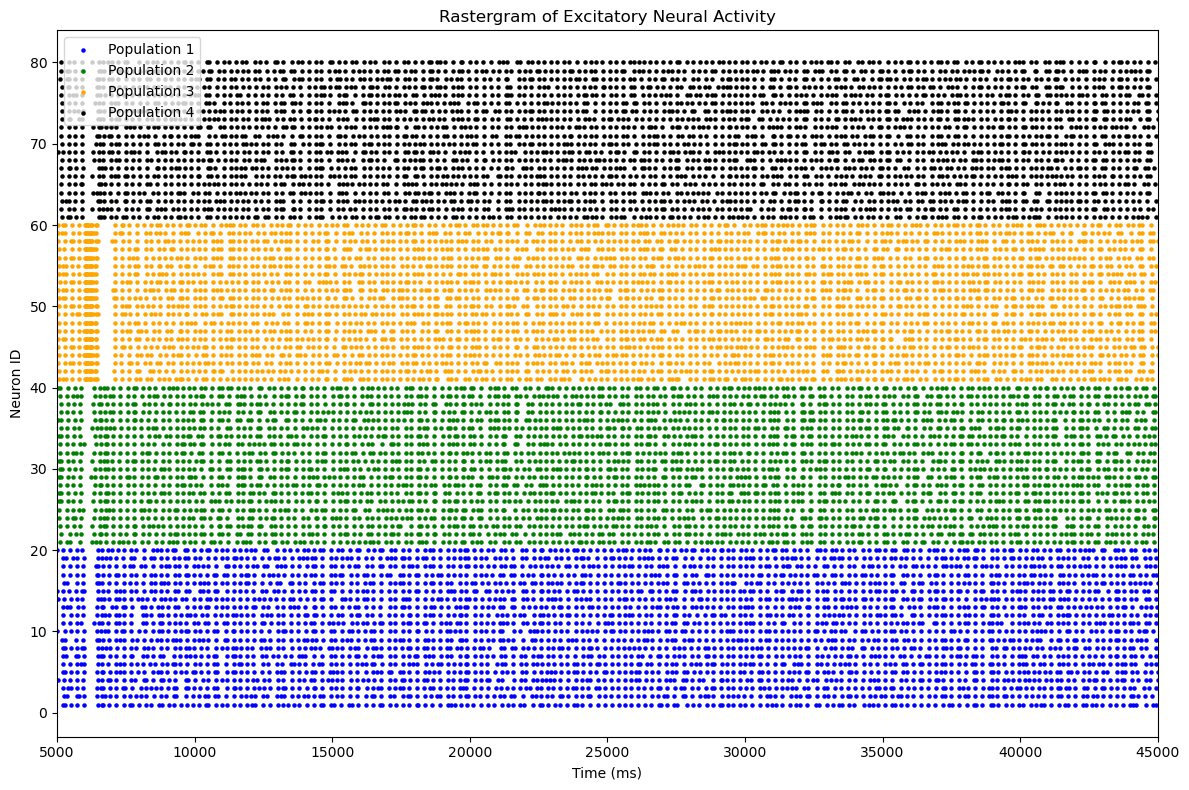

In [8]:
#plot of the rastegram of excitatory neurons
num_exc_pop=nest_pms['network']['num_exc_pop']
exc_pops_rastegram_plot(cropped_events, num_exc_pop, crop_pms)

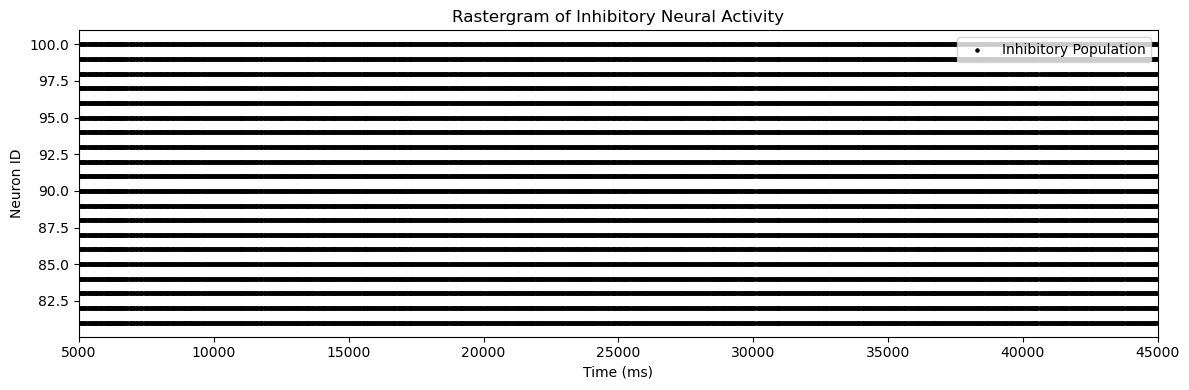

In [9]:
#plot of the rastegram of inhibitory neurons
inh_rastergram_plot(cropped_inh_events, crop_pms)

sampling_rate_Hz 5000.0
duration_ms 4.0
std_dev_ms 0.5
len of kernel 20


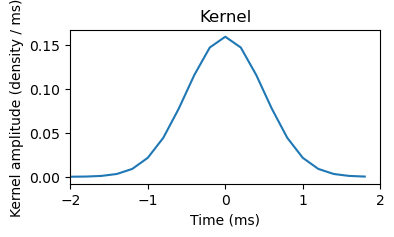

In [10]:
#preparing to smooth the single spike with the form of a spike event
sampling_rate_Hz = analysis_pms["analysis_sampling_freq_Hz"] #Hz sampling rate
print("sampling_rate_Hz", sampling_rate_Hz)
duration_ms = 4.0 # Duration of smoothing effect ms
print("duration_ms", duration_ms)
std_dev_ms = 0.5  # Standard deviation in ms
print("std_dev_ms", std_dev_ms)

single_spike_kernel = gaussian_kernel(duration_ms, sampling_rate_Hz, std_dev_ms)
print("len of kernel",len(single_spike_kernel))

kernel_plot(single_spike_kernel, sampling_rate_Hz)

In [11]:
#collect spike spikes from all populations in a single vector 
single_trace_spike_times = combine_spike_times_in_single_trace(cropped_events, num_exc_pop)

In [12]:
#Calculate combined firing rates
num_exc_pop=nest_pms['network']['num_exc_pop']
num_exc_neu_per_pop=nest_pms['network']['num_exc_neu_per_pop']
time_points, combined_firing_rate = \
    calculate_firing_rate(crop_pms, analysis_pms, single_trace_spike_times, num_exc_pop*num_exc_neu_per_pop)

In [13]:
instantaneous_firing_rate_plot=False
if instantaneous_firing_rate_plot:
    #plot of combined instantaneous firing rates   
    firing_rates_plot(time_points, combined_firing_rate, crop_pms) 

len of smoothed signal 199999
type of smoothed signal <class 'numpy.ndarray'>


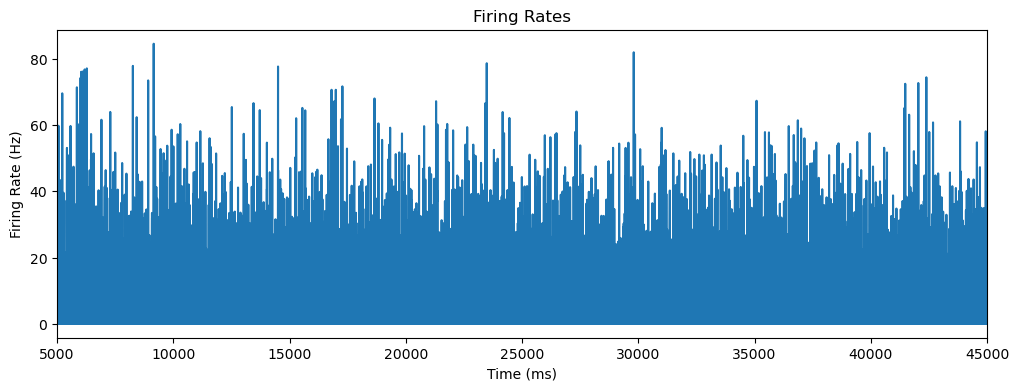

In [14]:
smoothed_spikes_firing_rate = smooth_signal(combined_firing_rate, single_spike_kernel)
print("len of smoothed signal", len(smoothed_spikes_firing_rate))
print("type of smoothed signal", type(smoothed_spikes_firing_rate))
firing_rates_plot(time_points, smoothed_spikes_firing_rate, crop_pms) 

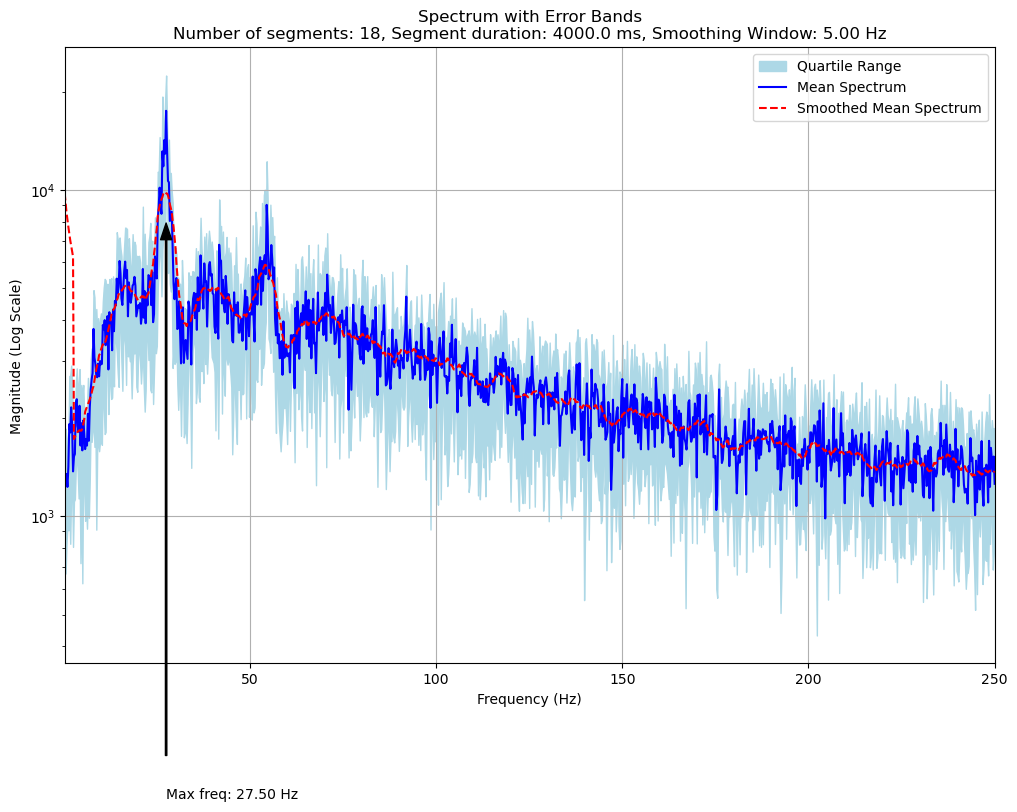

In [15]:
#dividing the data in segments for reliable spectral analysis
max_plot_freq_Hz=250.0
smoothing_length=20 #frequency samples
compute_spectrum_with_error_bands(smoothed_spikes_firing_rate, analysis_pms, max_plot_freq_Hz, smoothing_length)

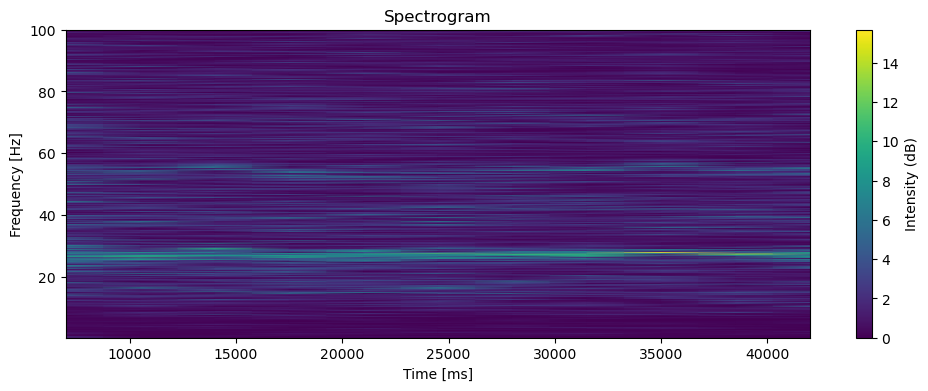

In [16]:
max_plot_freq_Hz=100

#Spectrogram plot
plot_spectrogram(time_points[0],\
                 smoothed_spikes_firing_rate,\
                 analysis_pms, max_plot_freq_Hz)

#Spectrogram plot
#plot_spectrogram(time_points[0], combined_firing_rate, analysis_pms)

sampling_rate_Hz 5000.0
duration_ms 100.0
std_dev_ms 12.0
len of kernel 500


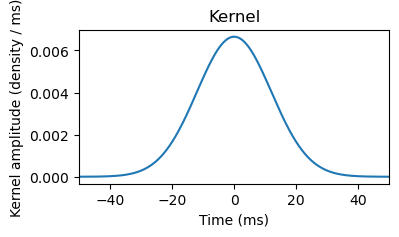

In [17]:
#smoothing the spike gaussians with synaptic times for ECG/LFP/ECoG like analysis
sampling_rate_Hz = analysis_pms["analysis_sampling_freq_Hz"] #Hz sampling rate
print("sampling_rate_Hz", sampling_rate_Hz)
duration_ms = 100.0 # Duration of smoothing effect ms
assert(crop_pms["duration_ms"]>=duration_ms)
print("duration_ms", duration_ms)
std_dev_ms = 12.0  # Standard deviation in ms
print("std_dev_ms", std_dev_ms)
tissue_response_kernel = gaussian_kernel(duration_ms, sampling_rate_Hz, std_dev_ms)
print("len of kernel",len(tissue_response_kernel))

kernel_plot(tissue_response_kernel, sampling_rate_Hz)

In [18]:
#smoothed_spikes_firing_rate = smooth_signal(combined_firing_rate, single_spike_kernel)
tissue_response_rate = smooth_signal(smoothed_spikes_firing_rate, tissue_response_kernel)

len of tissue signal 199999
type of tissue signal <class 'numpy.ndarray'>


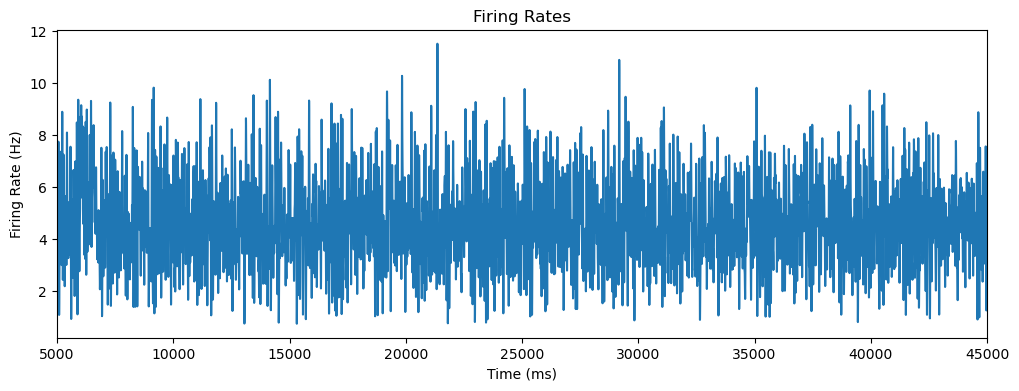

In [19]:
print("len of tissue signal", len(tissue_response_rate))
print("type of tissue signal", type(tissue_response_rate))
firing_rates_plot(time_points, tissue_response_rate, crop_pms) 

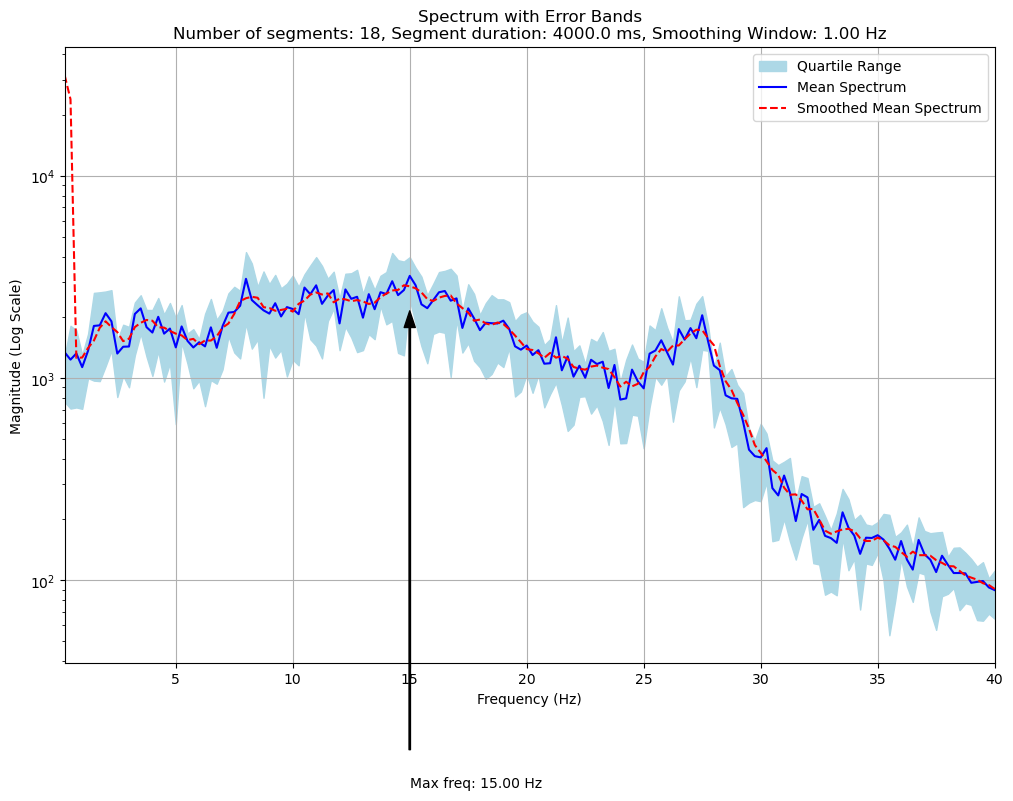

In [20]:
#dividing the data in segments for reliable spectral analysis
max_plot_freq_Hz=40
smoothing_length=4 #frequency samples
compute_spectrum_with_error_bands(tissue_response_rate, analysis_pms, max_plot_freq_Hz, smoothing_length)

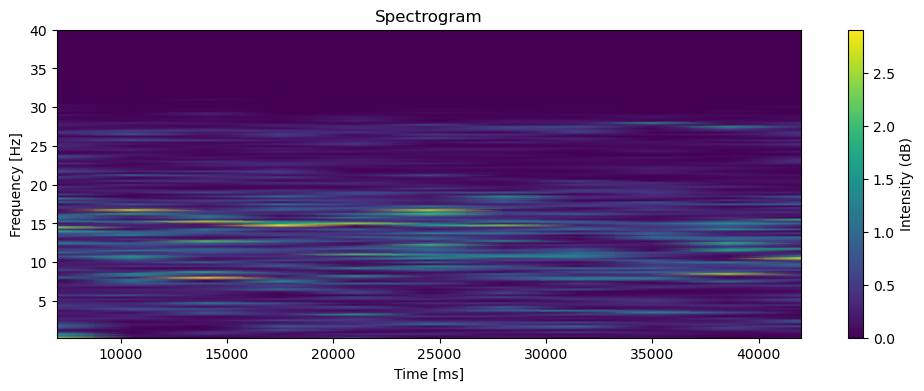

In [21]:
max_plot_freq_Hz=40
#Spectrogram plot
plot_spectrogram(time_points[0],\
                 tissue_response_rate,\
                 analysis_pms, max_plot_freq_Hz)

#Spectrogram plot
#plot_spectrogram(time_points[0], combined_firing_rate, analysis_pms)

In [22]:
plt.show()